Реалізувати розрахунки та побудову / візуалізацію на цифровій векторній карті сітку відстаней між пожежними станціями США. \
Кількість пожежних станцій для побудови сітки відстаней обрати самостійно. \
Розрахувати середню відстань між пожежними станціями. \
Провести верифікацію результатів розрахунку відстаней за одиницями виміру. \
\
Додатково: визначити щільність розташування пожежних станцій територією США; \
встановити та відобразити центроїди районів з найбільшою щільністю; \
відобразити межи п’яти районів з найбільшою щільністю на цифровій карті.

In [161]:
!pip install -q geopandas pandas matplotlib scikit-learn shapely requests numpy contextily

DEPRECATION: Loading egg at c:\programs\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [162]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import contextily as ctx
from sklearn.cluster import KMeans

In [163]:
# load
PATH = './Fire_Stations/Fire_Stations.shp'
fire_stations = gpd.read_file(PATH)
print('Кількість пожежних станцій:', len(fire_stations))

Кількість пожежних станцій: 52184


In [164]:
# random choice N fire stations
N_STATIONS = 15
selected = fire_stations.sample(n=N_STATIONS, random_state=42).copy()
selected = selected.reset_index(drop=True)

In [165]:
# system of coordinates
print('Система координат обраних станцій:', selected.crs)
if selected.crs != 'EPSG:3857':
    selected = selected.to_crs('EPSG:3857')  # Метри

Система координат обраних станцій: EPSG:3857


In [166]:
# calculate distances between fire stations
dist_matrix = np.zeros((N_STATIONS, N_STATIONS))
pairs = list(combinations(range(N_STATIONS), 2))
distances = []

for i, j in pairs:
    dist = selected.geometry[i].distance(selected.geometry[j])
    dist_matrix[i][j] = dist
    dist_matrix[j][i] = dist
    distances.append(dist)

In [167]:
# calculate average distance
average_distance = np.mean(distances)
print('Середня відстань між пожежними станціями:', average_distance, 'метрів')
print('Середня відстань в кілометрах:', average_distance / 1000, 'км')

Середня відстань між пожежними станціями: 1762155.0956670202 метрів
Середня відстань в кілометрах: 1762.15509566702 км


In [168]:
# save and verify results
print(f"Одиниці виміру EPSG:3857 переводимо в кілометри.")
distance_df = gpd.GeoDataFrame(dist_matrix, columns=[f"FS_{i}" for i in range(N_STATIONS)], index=[f"FS_{i}" for i in range(N_STATIONS)])
distance_df = distance_df / 1000  # Convert to kilometers
distance_df.to_csv('fire_station_distances.csv')
print("Результати збережено у 'fire_station_distances.csv'.")

Одиниці виміру EPSG:3857 переводимо в кілометри.
Результати збережено у 'fire_station_distances.csv'.


In [169]:
# head, round 2 decimal places
distance_df.round(2).head()

,FS_0,FS_1,FS_2,FS_3,FS_4,FS_5,FS_6,FS_7,FS_8,FS_9,FS_10,FS_11,FS_12,FS_13,FS_14
FS_0,0.00,946.26,1031.11,837.77,634.44,2002.82,2695.88,2418.87,1355.62,2215.90,987.61,2066.28,1672.10,2345.63,1255.07
FS_1,946.26,0.00,1179.20,1484.10,715.26,2507.43,2257.79,3066.44,438.11,2764.21,1587.23,1923.76,2300.38,2916.18,2073.55
FS_2,1031.11,1179.20,0.00,655.28,519.94,1353.68,3407.35,1967.39,1314.18,1620.08,645.66,1043.16,1233.25,1777.67,1280.17
FS_3,837.77,1484.10,655.28,0.00,792.23,1165.30,3513.27,1613.78,1763.46,1380.65,153.64,1580.82,850.27,1514.72,647.17
FS_4,634.44,715.26,519.94,792.23,0.00,1797.59,2896.67,2351.82,972.47,2051.33,880.02,1480.50,1586.80,2202.20,1418.79


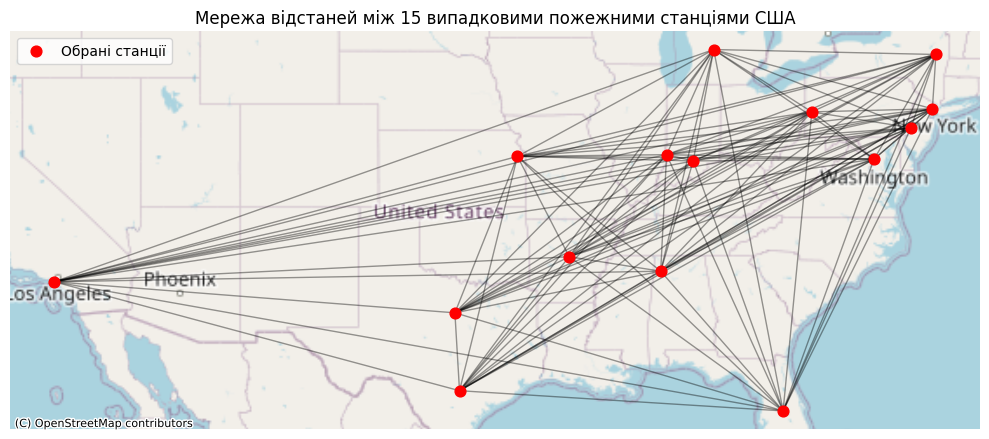

In [170]:
# visualize fire stations on a map
fig, ax = plt.subplots(figsize=(10, 8))
selected.plot(ax=ax, color='red', markersize=60, zorder=2, label='Обрані станції')

# Лінії між усіма парами
for i, j in pairs:
    x0, y0 = selected.geometry[i].x, selected.geometry[i].y
    x1, y1 = selected.geometry[j].x, selected.geometry[j].y
    ax.plot([x0, x1], [y0, y1], color='black', alpha=0.4, linewidth=1, zorder=1)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title(f"Мережа відстаней між {N_STATIONS} випадковими пожежними станціями США")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


Інформація про щільність кластерів:
Кластер 39: станцій = 2277, площа = 84585.61 км², щільність = 0.02692 станцій/км², в середньому 1 станція на 37.15 км²
Кластер 19: станцій = 1978, площа = 113313.95 км², щільність = 0.01746 станцій/км², в середньому 1 станція на 57.29 км²
Кластер 0: станцій = 1460, площа = 104862.08 км², щільність = 0.01392 станцій/км², в середньому 1 станція на 71.82 км²
Кластер 25: станцій = 2120, площа = 194183.53 км², щільність = 0.01092 станцій/км², в середньому 1 станція на 91.60 км²
Кластер 16: станцій = 1605, площа = 149737.39 км², щільність = 0.01072 станцій/км², в середньому 1 станція на 93.29 км²
Кластер 43: станцій = 1563, площа = 168799.04 км², щільність = 0.00926 станцій/км², в середньому 1 станція на 108.00 км²
Кластер 45: станцій = 1641, площа = 192381.15 км², щільність = 0.00853 станцій/км², в середньому 1 станція на 117.23 км²
Кластер 14: станцій = 1483, площа = 185015.50 км², щільність = 0.00802 станцій/км², в середньому 1 станція на 124.76 км²
Кла

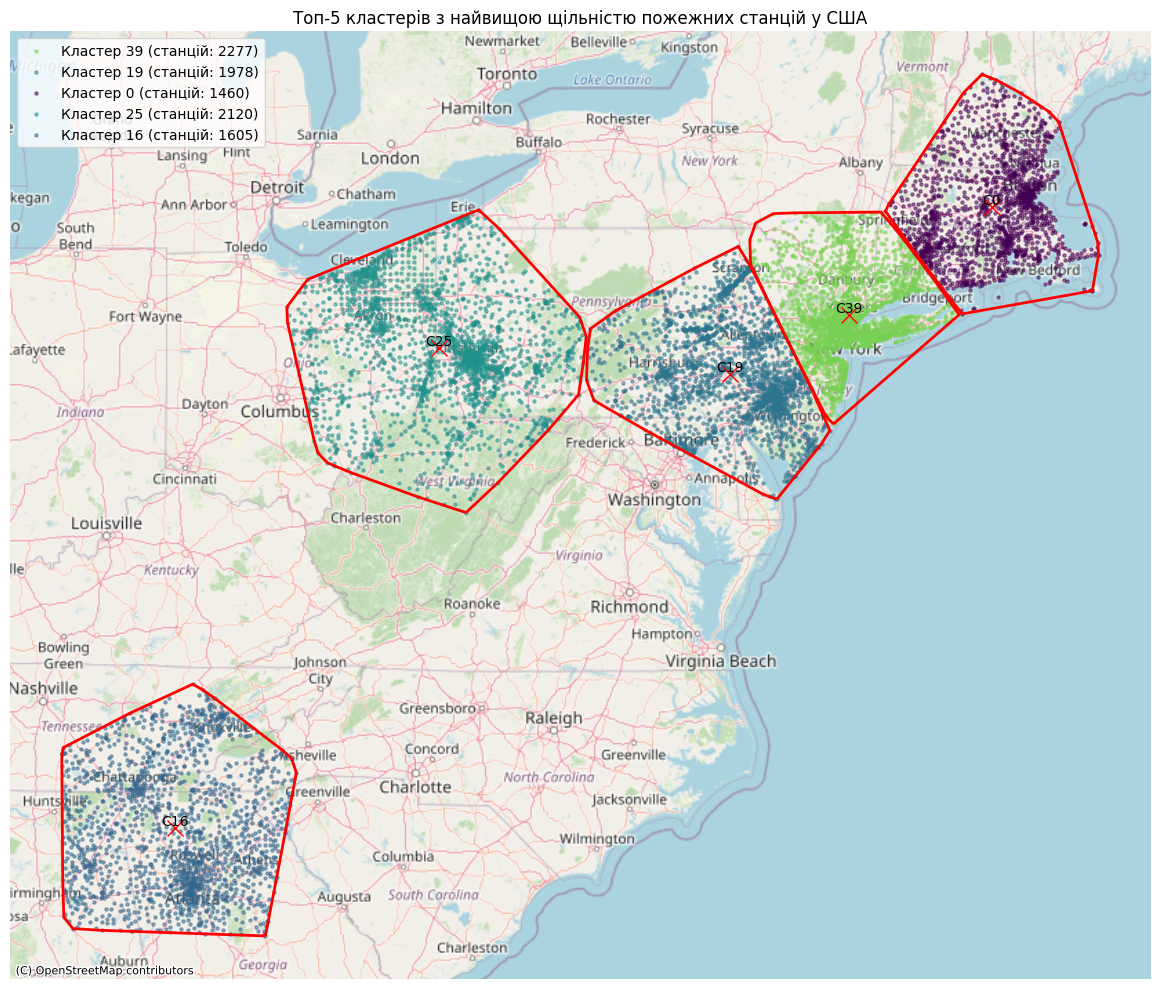

Інформація про топ-5 кластерів з найменшою щільністю:
Кластер 44: станцій = 308, площа = 600665.90 км², щільність = 0.00051 станцій/км², в середньому 1 станція на 1950.21 км²
Кластер 31: станцій = 46, площа = 392931.31 км², щільність = 0.00012 станцій/км², в середньому 1 станція на 8541.98 км²
Кластер 20: станцій = 137, площа = 1434396.02 км², щільність = 0.00010 станцій/км², в середньому 1 станція на 10470.04 км²
Кластер 6: станцій = 94, площа = 4713990.53 км², щільність = 0.00002 станцій/км², в середньому 1 станція на 50148.84 км²
Кластер 38: станцій = 77, площа = 4255838.34 км², щільність = 0.00002 станцій/км², в середньому 1 станція на 55270.63 км²


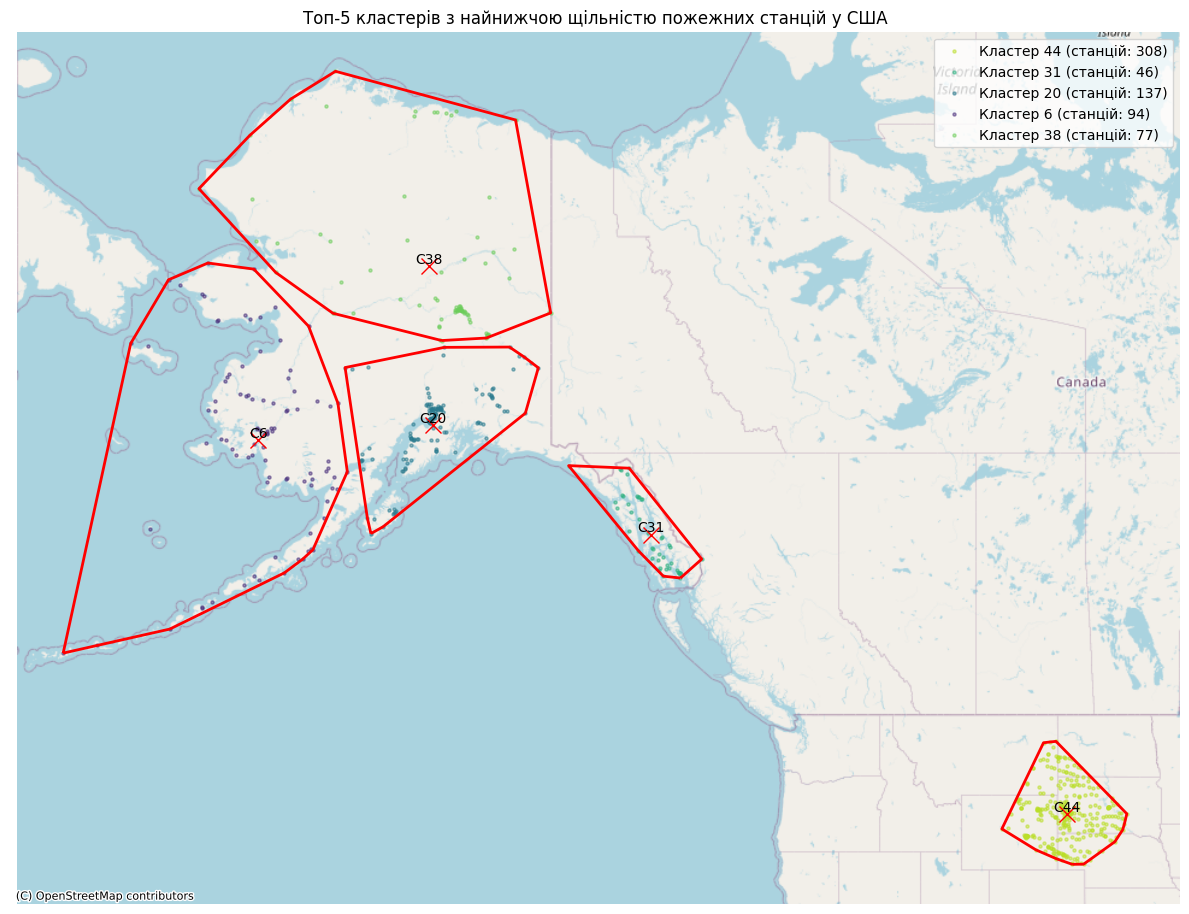

In [171]:
# Перетворити координати всіх станцій у метричну систему (Web Mercator)
fire_stations_3857 = fire_stations.to_crs(epsg=3857)
coords = fire_stations_3857.geometry.apply(lambda p: (p.x, p.y)).tolist()

# Кластеризація
N_CLUSTERS = 50
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(coords)

fire_stations_3857['cluster'] = labels

# Обчислити щільність для кожного кластера
density_list = []
for i in range(N_CLUSTERS):
    cluster_points = fire_stations_3857[fire_stations_3857['cluster'] == i]
    n_points = len(cluster_points)
    if n_points >= 3:
        polygon = cluster_points.geometry.union_all().convex_hull
        area_m2 = polygon.area
    else:
        area_m2 = 0.0
    density = n_points / (area_m2 / 1e6) if area_m2 > 0 else float('inf')
    density_list.append((i, n_points, area_m2, density))

# Відсортувати за щільністю (descending)
density_list.sort(key=lambda x: x[3], reverse=True)

# Вивести інформацію про щільність
print("Інформація про щільність кластерів:")
for i, n_points, area_m2, density in density_list:
    print(f"Кластер {i}: станцій = {n_points}, площа = {area_m2/1e6:.2f} км², щільність = {density:.5f} станцій/км², "
          f"в середньому 1 станція на {1/density:.2f} км²")
print('-' * 150)
# Середня щільність по США
average_density = sum(d[3] for d in density_list) / N_CLUSTERS
print(f"Середня щільність по США: {average_density:.5f} станцій/км², в середньому 1 станція на {1/average_density:.2f} км²")
print('-' * 150)

# Взяти топ-5 за щільністю
top_clusters = [d[0] for d in density_list[:5]]

# Вивід інформації про топ-5
print("Інформація про топ-5 кластерів з найбільшою щільністю:")
for i, n_points, area_m2, density in density_list[:5]:
    print(f"Кластер {i}: станцій = {n_points}, площа = {area_m2/1e6:.2f} км², щільність = {density:.5f} станцій/км², "
          f"в середньому 1 станція на {1/density:.2f} км²")

# Центроїди кластерів
centroids = kmeans.cluster_centers_

# Візуалізація
fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))

for i in top_clusters:
    cluster_points = fire_stations_3857[fire_stations_3857['cluster'] == i]
    cluster_points.plot(ax=ax, color=colors[i], markersize=5, alpha =0.5,
                        label=f'Кластер {i} (станцій: {len(cluster_points)})')

    if len(cluster_points) >= 3:
        polygon = cluster_points.geometry.union_all().convex_hull
        gpd.GeoSeries([polygon], crs=fire_stations_3857.crs).plot(
            ax=ax, edgecolor='red', facecolor='none', linewidth=2)

for i in top_clusters:
    x, y = centroids[i]
    ax.plot(x, y, marker='x', color='red', markersize=12)
    ax.text(x, y, f'C{i}', color='black', fontsize=10, ha='center', va='bottom')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_aspect('equal')
ax.axis('off')

plt.title("Топ-5 кластерів з найвищою щільністю пожежних станцій у США")
plt.legend()
plt.tight_layout()
plt.show()

# топ 5 кластерів з найменьшою щільністю
# Вивести інформацію про топ-5 кластерів з найменшою щільністю
print("Інформація про топ-5 кластерів з найменшою щільністю:")
for i, n_points, area_m2, density in density_list[-5:]:
    print(f"Кластер {i}: станцій = {n_points}, площа = {area_m2/1e6:.2f} км², щільність = {density:.5f} станцій/км², "
          f"в середньому 1 станція на {1/density:.2f} км²")

# Візуалізація топ-5 кластерів з найменшою щільністю
fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))

for i in density_list[-5:]:
    cluster_points = fire_stations_3857[fire_stations_3857['cluster'] == i[0]]
    cluster_points.plot(ax=ax, color=colors[i[0]], markersize=5, alpha=0.5,
                        label=f'Кластер {i[0]} (станцій: {i[1]})')

    if len(cluster_points) >= 3:
        polygon = cluster_points.geometry.union_all().convex_hull
        gpd.GeoSeries([polygon], crs=fire_stations_3857.crs).plot(
            ax=ax, edgecolor='red', facecolor='none', linewidth=2)
    x, y = centroids[i[0]]
    ax.plot(x, y, marker='x', color='red', markersize=12)
    ax.text(x, y, f'C{i[0]}', color='black', fontsize=10, ha='center', va='bottom')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Топ-5 кластерів з найнижчою щільністю пожежних станцій у США")
plt.legend()
plt.tight_layout()
plt.show()
